In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')


with open('/content/drive/MyDrive/checkpoints/checkpoint2.pkl', 'rb') as f:
    checkpoint2 = pkl.load(f)

# Accessing variables
X_train = checkpoint2['X_train']
y_train = checkpoint2['y_train']
X_val = checkpoint2['X_val']
X_test = checkpoint2['X_test']
y_val = checkpoint2['y_val']
y_test = checkpoint2['y_test']
data_cleaned = checkpoint2['data_cleaned']

print("Checkpoint loaded successfully")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
Checkpoint loaded successfully


In [ ]:
import re
import pandas as pd
from sklearn.cluster import KMeans

# Define function to extract features from resume text
def extract_resume_features(resume_text):
    # Extract number of skills (basic approximation using keywords like 'skill')
    num_skills = len(re.findall(r'skill[s]?', resume_text, re.IGNORECASE))

    # Extract work experience based on presence of keywords like 'experience' or job titles
    experience_years = len(re.findall(r'\b(?:experience|manager|engineer|developer|analyst)\b', resume_text, re.IGNORECASE))

    # Count the number of job positions (approximation)
    num_positions = len(re.findall(r'\b(?:intern|manager|engineer|developer|analyst|consultant)\b', resume_text, re.IGNORECASE))

    # Extract educational qualifications
    education_mentions = len(re.findall(r'\b(?:bachelor|master|phd|degree|university)\b', resume_text, re.IGNORECASE))

    return [num_skills, experience_years, num_positions, education_mentions]

# Extract features from each resume in data_cleaned['resume']
features = [extract_resume_features(resume) for resume in data_cleaned['resume']]

# Create DataFrame to analyze features
columns = ['Num_Skills', 'Experience_Years', 'Num_Positions', 'Education_Mentions']
resume_df = pd.DataFrame(features, columns=columns)
print("Resume Feature DataFrame:")
print(resume_df.head())

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming two clusters: cold start and non-cold start
resume_df['Cluster'] = kmeans.fit_predict(resume_df)

# Analyze clusters
print("\nCluster Analysis:")
print(resume_df.groupby('Cluster').mean())

Resume Feature DataFrame:
   Num_Skills  Experience_Years  Num_Positions  Education_Mentions
0           5                 6              2                   2
1           2                 4              2                   1
2           3                11              0                   1
3           4                 6              4                   2
4           2                 5              3                   8

Cluster Analysis:
         Num_Skills  Experience_Years  Num_Positions  Education_Mentions
Cluster                                                                 
0          2.117392          6.840099       5.005933            2.035689
1          2.902202         23.615627      13.275564            2.114316


In [ ]:
# prompt: I want to know how many instances there are in the two clusters

cluster_counts = resume_df['Cluster'].value_counts()
print("\nNumber of Instances in Each Cluster:")
print(cluster_counts)



Number of Instances in Each Cluster:
Cluster
0    21407
1     7628
Name: count, dtype: int64


In [ ]:
import dateutil.parser

def extract_working_years(resume_text):
    # Use regex to extract date-like entities
    date_patterns = re.findall(r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)?\s?\d{4}\b', resume_text)
    dates = []

    for date in date_patterns:
        try:
            parsed_date = dateutil.parser.parse(date, fuzzy=True)
            dates.append(parsed_date)
        except ValueError:
            continue

    if len(dates) > 0:
        # Assuming dates are in chronological order, calculate total experience
        dates = sorted(dates)
        experience_years = (dates[-1] - dates[0]).days / 365.25
    else:
        experience_years = 0

    return experience_years

working_years = [extract_working_years(resume) for resume in data_cleaned['resume']]
working_years_df = pd.DataFrame(working_years, columns=['Working_Years'])
print("Working Years DataFrame:")
print(working_years_df.head())
print(working_years_df.describe())

Working Years DataFrame:
   Working_Years
0              0
1              0
2              0
3              0
4              0
       Working_Years
count        29035.0
mean             0.0
std              0.0
min              0.0
25%              0.0
50%              0.0
75%              0.0
max              0.0


In [ ]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 11.9 MB/s eta 0:00:00


In [ ]:
# Imports
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# For reproducibility
RANDOM_STATE = 42

# Display settings
pd.set_option('display.max_columns', None)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
def extract_basic_features(resume_text):
    # Number of generic skills mentions
    num_skills = len(re.findall(r'skill[s]?', resume_text, re.IGNORECASE))

    # Number of experience-related keywords
    experience_years = len(re.findall(r'\b(?:experience|manager|engineer|developer|analyst)\b', resume_text, re.IGNORECASE))

    # Number of job positions
    num_positions = len(re.findall(r'\b(?:intern|manager|engineer|developer|analyst|consultant)\b', resume_text, re.IGNORECASE))

    # Number of education mentions
    education_mentions = len(re.findall(r'\b(?:bachelor|master|phd|degree|university)\b', resume_text, re.IGNORECASE))

    return [num_skills, experience_years, num_positions, education_mentions]

# Define a list of common technical and soft skills
skill_keywords = [
    'python', 'java', 'sql', 'machine learning', 'data analysis',
    'project management', 'communication', 'team leadership',
    'excel', 'c\+\+', 'javascript', 'react', 'node\.js', 'aws',
    'docker', 'kubernetes', 'tensorflow', 'pandas', 'numpy',
    'problem-solving', 'adaptability', 'creativity'
    # Add more relevant skills as needed
]

def extract_specific_skills(resume_text):
    skills_found = [skill for skill in skill_keywords if re.search(r'\b' + skill + r'\b', resume_text, re.IGNORECASE)]
    return len(skills_found), skills_found

def extract_experience_years_detailed(resume_text):
    # Find patterns like "2015-2020" or "2015 to 2020"
    patterns = re.findall(r'(\b\d{4}\b)\s*(?:-|to)\s*(\b\d{4}\b)', resume_text, re.IGNORECASE)
    years = 0
    for start, end in patterns:
        try:
            years += int(end) - int(start)
        except:
            continue
    return years if years > 0 else 0

education_levels = ['Bachelor', 'Master', 'PhD', 'Associate', 'Diploma']

def extract_education_details(resume_text):
    degrees = [degree for degree in education_levels if re.search(r'\b' + degree + r'\b', resume_text, re.IGNORECASE)]
    return len(degrees), degrees
def extract_resume_length(resume_text):
    return len(resume_text.split())
certification_keywords = ['certification', 'certified', 'award', 'awarded', 'honor', 'certification in']

def extract_certifications(resume_text):
    return len(re.findall(r'\b(?:' + '|'.join(certification_keywords) + r')\b', resume_text, re.IGNORECASE))
def extract_projects_publications(resume_text):
    projects = len(re.findall(r'\bproject[s]?\b', resume_text, re.IGNORECASE))
    publications = len(re.findall(r'\bpublication[s]?\b', resume_text, re.IGNORECASE))
    return projects, publications
languages = ['english', 'spanish', 'french', 'german', 'chinese', 'japanese', 'arabic', 'hindi', 'portuguese', 'italian', 'russian']

def extract_languages(resume_text):
    langs_found = [lang for lang in languages if re.search(r'\b' + re.escape(lang) + r'\b', resume_text, re.IGNORECASE)]
    return len(langs_found), langs_found
soft_skills = ['communication', 'teamwork', 'leadership', 'problem-solving', 'adaptability', 'creativity', 'time management', 'critical thinking']

def extract_soft_skills(resume_text):
    skills = [skill for skill in soft_skills if re.search(r'\b' + re.escape(skill) + r'\b', resume_text, re.IGNORECASE)]
    return len(skills), skills
def extract_nlp_features(resume_text):
    doc = nlp(resume_text)
    num_entities = len(doc.ents)
    orgs = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    schools = [ent.text for ent in doc.ents if ent.label_ == 'ORG' and 'University' in ent.text or 'Institute' in ent.text or 'College' in ent.text]
    return num_entities, len(orgs), len(schools)



In [ ]:
def extract_resume_features(resume_text):
    # Basic Features
    num_skills_basic, experience_years_basic, num_positions_basic, education_mentions_basic = extract_basic_features(resume_text)

    # Detailed Experience Extraction (Optional: You can choose to keep or remove this based on your requirements)
    experience_years_detailed = extract_experience_years_detailed(resume_text)

    # If you prefer to use the detailed experience, you can overwrite the basic one
    # Otherwise, you might want to keep both or choose the most accurate one
    experience_years = experience_years_detailed if experience_years_detailed > experience_years_basic else experience_years_basic

    # Number of Positions (Already extracted as num_positions_basic)
    num_positions = num_positions_basic  # Avoid recalculating

    # Education Mentions and Details
    education_mentions, degrees = extract_education_details(resume_text)

    # Specific Skills
    specific_skills_count, specific_skills = extract_specific_skills(resume_text)

    # Resume Length
    resume_length = extract_resume_length(resume_text)

    # Certifications
    certifications = extract_certifications(resume_text)

    # Projects and Publications
    projects, publications = extract_projects_publications(resume_text)

    # Languages
    languages_count, languages_found = extract_languages(resume_text)

    # Soft Skills
    soft_skills_count, soft_skills_found = extract_soft_skills(resume_text)

    # NLP Features
    num_entities, num_orgs, num_schools = extract_nlp_features(resume_text)

    return [
        num_skills_basic, experience_years, num_positions, education_mentions,
        specific_skills_count, resume_length, certifications,
        projects, publications, languages_count,
        soft_skills_count, num_entities, num_orgs, num_schools
    ]


In [ ]:
# Example: Loading data_cleaned (Replace this with your actual data loading method)
# data_cleaned = pd.read_csv('your_resume_data.csv')  # Example
# For demonstration, here's a mock DataFrame

# Extract features from each resume
features = [extract_resume_features(resume) for resume in data_cleaned['resume']]

# Define new columns based on the extract_resume_features output
columns = [
    'Num_Skills_Basic', 'Experience_Years', 'Num_Positions', 'Education_Mentions',
    'Specific_Skills_Count', 'Resume_Length', 'Certifications',
    'Projects', 'Publications', 'Languages_Count',
    'Soft_Skills_Count', 'Num_Entities', 'Num_ORGs', 'Num_Schools'
]
resume_df = pd.DataFrame(features, columns=columns)

# Display the first few rows of the feature DataFrame
print("Resume Feature DataFrame:")
print(resume_df.head())


Resume Feature DataFrame:
   Num_Skills_Basic  Experience_Years  Num_Positions  Education_Mentions  \
0                 5                 6              2                   1   
1                 2                 4              2                   0   
2                 3                11              0                   1   
3                 4                 6              4                   1   
4                 2                 5              3                   1   

   Specific_Skills_Count  Resume_Length  Certifications  Projects  \
0                      2            778               0         4   
1                      3            209               0         1   
2                      1            377               0         0   
3                      4            370               0         0   
4                      2            512               0         0   

   Publications  Languages_Count  Soft_Skills_Count  Num_Entities  Num_ORGs  \
0             0        

In [ ]:
# Checkpoint 3
import pickle as pkl
import numpy as np
import pandas as pd

checkpoint3 = {
    'resume_df': resume_df,
    'data_cleaned': data_cleaned
}


import os

checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint3.pkl')
with open(checkpoint_path, 'wb') as f:
    pkl.dump(checkpoint3, f)

print("Checkpoint 3 saved successfully ")

Checkpoint 3 saved successfully 


In [ ]:
# Checkpoint 3
import pickle as pkl
import numpy as np
import pandas as pd


with open('/content/drive/MyDrive/checkpoints/checkpoint3.pkl', 'rb') as f:
    checkpoint3 = pkl.load(f)

# Accessing variables
resume_df = checkpoint3['resume_df']
data_cleaned = checkpoint3['data_cleaned']

print("Checkpoint loaded successfully")

Checkpoint loaded successfully


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the combined features
scaled_features = scaler.fit_transform(resume_df.copy())

# Convert back to DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=resume_df.columns)

# Display scaled features
print("Scaled Features DataFrame:")
print(scaled_features_df.head())


Scaled Features DataFrame:
   Num_Skills_Basic  Experience_Years  Num_Positions  Education_Mentions  \
0          1.510203         -0.582955      -0.924313           -0.034900   
1         -0.182581         -0.805146      -0.924313           -1.269146   
2          0.381680         -0.027476      -1.281294           -0.034900   
3          0.945941         -0.582955      -0.567333           -0.034900   
4         -0.182581         -0.694050      -0.745823           -0.034900   

   Specific_Skills_Count  Resume_Length  Certifications  Projects  \
0              -0.474564       0.136655       -0.439727 -0.087677   
1              -0.058080      -0.819218       -0.439727 -0.419868   
2              -0.891048      -0.536991       -0.439727 -0.530598   
3               0.358404      -0.548751       -0.439727 -0.530598   
4              -0.474564      -0.310203       -0.439727 -0.530598   

   Publications  Languages_Count  Soft_Skills_Count  Num_Entities  Num_ORGs  \
0     -0.144739       

In [ ]:
# Initialize KMeans with the chosen number of clusters
optimal_k = 2  # Since there are only two clusters in literature
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit and predict cluster labels
scaled_features_df['Cluster'] = kmeans.fit_predict(scaled_features_df)

# Optionally, merge cluster labels with the original data
data_cleaned['Cluster'] = scaled_features_df['Cluster']

# Display cluster assignments
print("Cluster Assignments:")
print(data_cleaned[['resume', 'Cluster']].head())



Cluster Assignments:
                                              resume  Cluster
0  database administrator span classhldatabasespa...        0
1  database administrator span classhldatabasespa...        0
2  oracle database administrator oracle span clas...        0
3  amazon redshift administrator etl developer bu...        0
4  scrum master scrum master scrum master richmon...        0


In [ ]:
import random

# Filter test indices from data_cleaned
test_indices = data_cleaned.index[data_cleaned.test_mask.cpu().numpy()]

# Filter the test indices to get cold start and non-cold start test instances
cold_start_test_indices = [idx for idx in test_indices if data_cleaned.loc[idx, 'Cluster'] == cold_start_cluster]
non_cold_start_test_indices = [idx for idx in test_indices if data_cleaned.loc[idx, 'Cluster'] == non_cold_start_cluster]

# Randomly sample 10 instances from each cluster within the test set
num_samples = 10
sampled_cold_start_indices = random.sample(cold_start_test_indices, min(num_samples, len(cold_start_test_indices)))
sampled_non_cold_start_indices = random.sample(non_cold_start_test_indices, min(num_samples, len(non_cold_start_test_indices)))

# Combine sampled indices
sampled_indices = sampled_cold_start_indices + sampled_non_cold_start_indices

# Extract the sampled data for further analysis
sampled_data = data[sampled_indices]

# Display the sampled indices and data
print(f"Sampled Cold Start Test Indices: {sampled_cold_start_indices}")
print(f"Sampled Non-Cold Start Test Indices: {sampled_non_cold_start_indices}")
print("\nSampled Data for Analysis:")
print(sampled_data)


AttributeError: 'DataFrame' object has no attribute 'test_mask'

In [ ]:
# Analyze clusters by computing the mean of each feature
print("\nCluster Analysis (Mean Values):")
print(scaled_features_df.groupby('Cluster').mean())



Cluster Analysis (Mean Values):
         Num_Skills_Basic  Experience_Years  Num_Positions  \
Cluster                                                      
0               -0.151103         -0.434135      -0.330159   
1                0.462672          1.329311       1.010938   

         Education_Mentions  Specific_Skills_Count  Resume_Length  \
Cluster                                                             
0                 -0.050577              -0.340525      -0.451590   
1                  0.154865               1.042678       1.382757   

         Certifications  Projects  Publications  Languages_Count  \
Cluster                                                            
0              0.007879 -0.202232     -0.003532         0.020446   
1             -0.024124  0.619229      0.010815        -0.062606   

         Soft_Skills_Count  Num_Entities  Num_ORGs  Num_Schools  
Cluster                                                          
0                -0.139390     -0.41

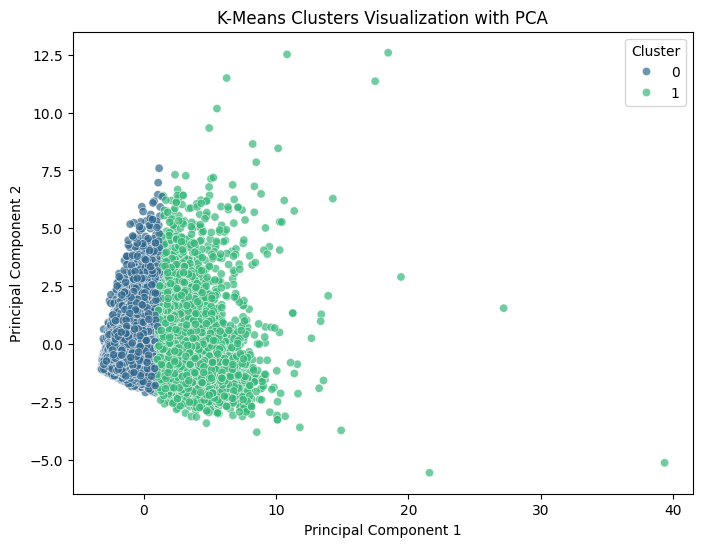

In [ ]:
# Initialize PCA for 2 components
pca = PCA(n_components=2, random_state=RANDOM_STATE)

# Fit and transform the scaled features
principal_components = pca.fit_transform(scaled_features_df.drop('Cluster', axis=1))

# Create a DataFrame with principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = scaled_features_df['Cluster']

# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principal_df, palette='viridis', alpha=0.7)
plt.title('K-Means Clusters Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
